In [ ]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Scikit-learn: preprocessing, model selection, metrics, and models
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# LightGBM, XGBoost, and CatBoost
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Statistical tests
from scipy.stats import f_oneway

# Timing utility
import time

In [ ]:
crashes = pd.read_csv('/kaggle/input/chicago-traffic-crashes-dataset-for-modelling/data_crashes.csv')
people = pd.read_csv('/kaggle/input/chicago-traffic-crashes-dataset-for-modelling/data_people.csv')
vehicles = pd.read_csv('/kaggle/input/chicago-traffic-crashes-dataset-for-modelling/data_vehicles.csv')

# Dự đoán chỉ với bộ crashes

## Tìm đặc trưng quan trọng bằng WoE và IV

In [ ]:
def calc_woe_iv(df, feature, target):
    lst = []
    for val in tqdm(df[feature].unique(), desc=f"Calculating WoE and IV for {feature}"):
        count = df[df[feature] == val].shape[0]
        count_event = df[(df[feature] == val) & (df[target] == 1)].shape[0]
        count_non_event = df[(df[feature] == val) & (df[target] == 0)].shape[0]

        event_rate = count_event / df[df[target] == 1].shape[0]
        non_event_rate = count_non_event / df[df[target] == 0].shape[0]

        # Avoid division by zero
        if event_rate == 0 or non_event_rate == 0:
            woe = 0
        else:
            woe = np.log(event_rate / non_event_rate)

        iv = (event_rate - non_event_rate) * woe

        lst.append({'Value': val, 'WoE': woe, 'IV': iv})

    woe_iv_df = pd.DataFrame(lst)
    total_iv = woe_iv_df['IV'].sum()

    return woe_iv_df, total_iv

def plot_iv(iv_dict):
    """
    Plot Information Value (IV) for features.

    Parameters:
    iv_dict (dict): A dictionary with feature names as keys and IV values as values.
    """
    features = list(iv_dict.keys())
    iv_values = list(iv_dict.values())

    plt.figure(figsize=(12, 8))
    bars = plt.barh(features, iv_values, color='skyblue', edgecolor='black')
    plt.xlabel('Information Value (IV)', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title('Information Value (IV) for Features', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Annotate bars to highlight whether they are above or below the threshold
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
                 f'{width:.2f}',
                 ha='left', va='center',
                 fontsize=10, color='black' if width >= 0.02 else 'red')

    plt.show()

In [ ]:
crashes_for_iv = crashes.copy()
cat_features = crashes_for_iv.select_dtypes(include=['object']).columns
num_features = crashes_for_iv.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in cat_features:
    crashes_for_iv[feature] = le.fit_transform(crashes_for_iv[feature])
for feature in num_features:
    crashes_for_iv[feature] = pd.qcut(crashes_for_iv[feature], q=10, duplicates='drop')

In [ ]:
features = list(crashes_for_iv.drop(columns=['crash_record_id', 'crash_date', 'most_severe_injury'],axis = 1).columns)

In [ ]:
iv_dict = {}

# Calculate IV for each feature and store it in the dictionary
for feature in features:
    _, iv = calc_woe_iv(crashes_for_iv, feature, 'most_severe_injury')
    iv_dict[feature] = iv

Calculating WoE and IV for posted_speed_limit: 100%|██████████| 3/3 [00:00<00:00, 45.30it/s]
Calculating WoE and IV for traffic_control_device: 100%|██████████| 18/18 [00:00<00:00, 111.64it/s]
Calculating WoE and IV for damage: 100%|██████████| 3/3 [00:00<00:00, 49.58it/s]
Calculating WoE and IV for prim_contributory_cause: 100%|██████████| 38/38 [00:00<00:00, 113.18it/s]
Calculating WoE and IV for sec_contributory_cause: 100%|██████████| 38/38 [00:00<00:00, 120.31it/s]
Calculating WoE and IV for longitude: 100%|██████████| 10/10 [00:00<00:00, 71.92it/s]
Calculating WoE and IV for injuries_incapacitating: 100%|██████████| 1/1 [00:00<00:00, 28.96it/s]
Calculating WoE and IV for injuries_non_incapacitating: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s]
Calculating WoE and IV for injuries_reported_not_evident: 100%|██████████| 1/1 [00:00<00:00, 28.21it/s]
Calculating WoE and IV for injuries_no_indication: 100%|██████████| 4/4 [00:00<00:00, 57.96it/s]
Calculating WoE and IV for injuries_un

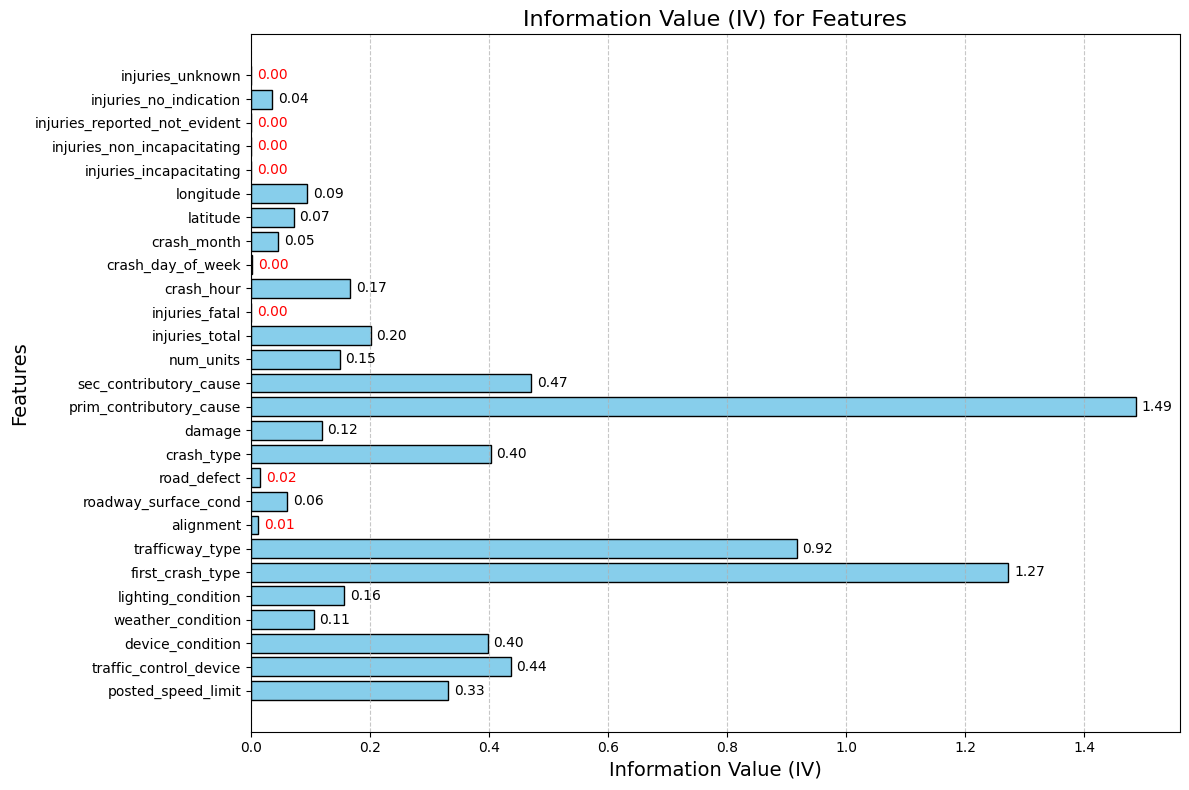

In [ ]:
plot_iv(iv_dict)

In [ ]:
def drop_low_iv_features(df, iv_dict, threshold=0.02):
    low_iv_features = [feature for feature, iv in iv_dict.items() if iv < threshold]
    related_features_to_drop = [feature for feature in df.columns if feature.endswith('_binned')]

    for feature in low_iv_features:
        if "_binned" in feature:
            original_feature = feature.replace("_binned", "")
            if original_feature in df.columns:
                related_features_to_drop.append(original_feature)

    all_features_to_drop = list(set(low_iv_features + related_features_to_drop))
    cleaned_df = df.drop(columns=all_features_to_drop, inplace=False)
    return cleaned_df

In [ ]:
chosen_crashes = drop_low_iv_features(crashes, iv_dict, threshold=0.02)
chosen_crashes.drop(columns=['crash_record_id', 'crash_date'], inplace=True)

## Kiểm định biến số bằng ANOVA test

In [ ]:
def evaluate_anova(df, target_column):
    results = []
    for column in df.select_dtypes(include=['int64', 'float64']).columns:
        if column != target_column:
            groups = [df[df[target_column] == cat][column] for cat in df[target_column].unique()]
            f_stat, p_value = f_oneway(*groups)
            results.append({
                "Column": column,
                "F-statistic": f_stat,
                "P-value": p_value
            })
    return pd.DataFrame(results)
target_column = "most_severe_injury"
anova_results = evaluate_anova(chosen_crashes, target_column)

In [ ]:
anova_results

,Column,F-statistic,P-value
0,posted_speed_limit,430.417783,0.000000e+00
1,num_units,560.965287,0.000000e+00
2,injuries_total,140829.823165,0.000000e+00
3,crash_hour,25.138406,1.976235e-25
4,crash_month,22.460075,1.350578e-22
5,latitude,8.089677,1.213997e-07
6,longitude,1.260533,2.778754e-01
7,injuries_no_indication,3791.787961,0.000000e+00


In [ ]:
chosen_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302020 entries, 0 to 302019
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   posted_speed_limit       302020 non-null  int64  
 1   traffic_control_device   302020 non-null  object 
 2   device_condition         302020 non-null  object 
 3   weather_condition        302020 non-null  object 
 4   lighting_condition       302020 non-null  object 
 5   first_crash_type         302020 non-null  object 
 6   trafficway_type          302020 non-null  object 
 7   roadway_surface_cond     302020 non-null  object 
 8   crash_type               302020 non-null  object 
 9   damage                   302020 non-null  object 
 10  prim_contributory_cause  302020 non-null  object 
 11  sec_contributory_cause   302020 non-null  object 
 12  num_units                302020 non-null  int64  
 13  most_severe_injury       302020 non-null  object 
 14  inju

## Xây dựng mô hình dự đoán mức độ nghiêm trọng của tai nạn dựa vào điều kiện tai nạn

In [ ]:
X = chosen_crashes.drop(columns=['most_severe_injury'])
y = chosen_crashes['most_severe_injury']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Chạy và đánh giá model

In [ ]:
# Cột phân loại và số
categorical_features = [
    'traffic_control_device', 'device_condition', 'weather_condition',
    'lighting_condition', 'first_crash_type', 'trafficway_type',
    'roadway_surface_cond', 'crash_type', 'damage',
    'prim_contributory_cause', 'sec_contributory_cause'
]
numerical_features = [
    'posted_speed_limit', 'num_units', 'injuries_total',
    'crash_hour', 'crash_month', 'latitude', 'longitude',
    'injuries_no_indication'
]

# Tiền xử lý dữ liệu
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Định nghĩa các mô hình
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    "SGDClassifier": SGDClassifier(random_state=42, max_iter=1000, tol=1e-3, class_weight='balanced'),
    "LightGBM": lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    "CatBoost": CatBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=42, verbose=0)
}

# Lưu kết quả
results = []

# Đánh giá từng mô hình
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1-score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "CV Mean Accuracy": np.mean(scores),
        "CV Std Accuracy": np.std(scores)
    })

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 161077, number of used features: 19
[LightGBM] [Info] Start training from score -5.995676
[LightGBM] [Info] Start training from score -6.732142
[LightGBM] [Info] Start training from score -4.078680
[LightGBM] [Info] Start training from score -0.170876
[LightGBM] [Info] Start training from score -2.437340
[LightGBM] [Info] Start training from score -3.014514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

## Hiển thị kết quả

In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1-score,CV Mean Accuracy,CV Std Accuracy
0,Random Forest,0.934309,0.924408,0.934309,0.915942,0.934143,0.000377
1,SGDClassifier,0.853851,0.913749,0.853851,0.875081,0.893604,0.042025
2,LightGBM,0.934756,0.927319,0.934756,0.923880,0.934081,0.000518
3,XGBoost,0.934706,0.930863,0.934706,0.922415,0.934706,0.000269
4,CatBoost,0.934226,0.923052,0.934226,0.917163,0.934156,0.000163


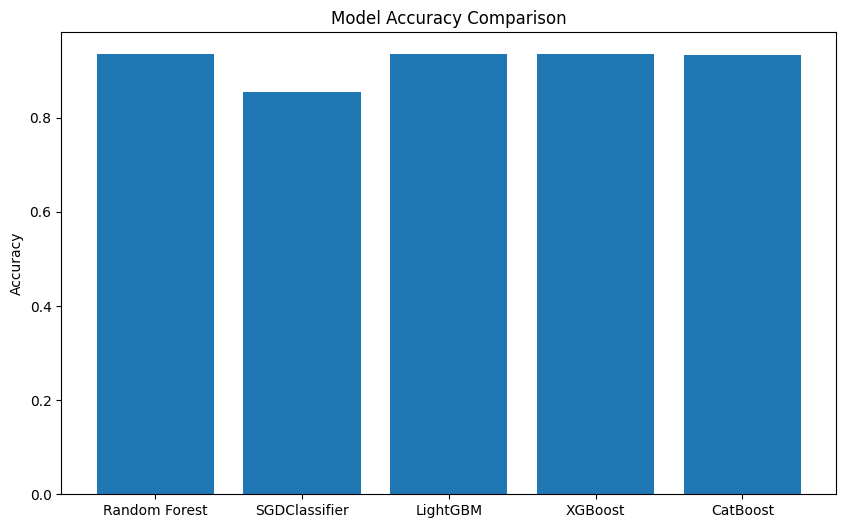

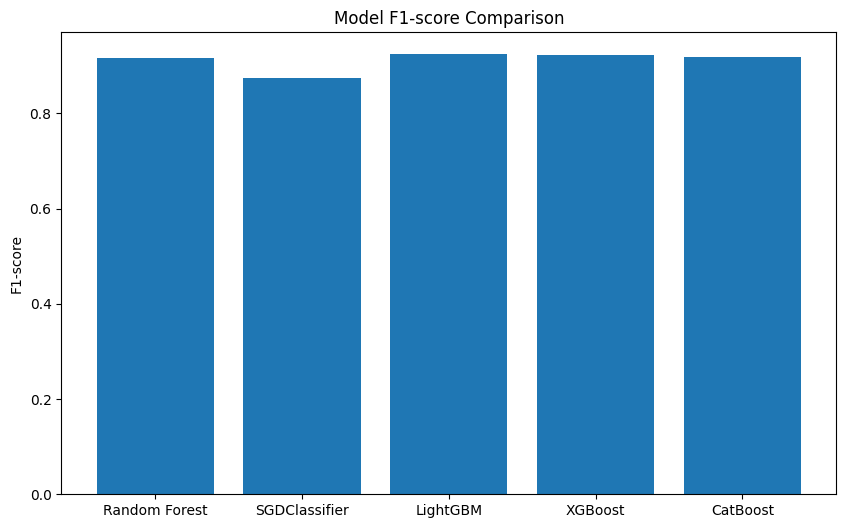

In [ ]:
# Biểu diễn kết quả bằng biểu đồ
import matplotlib.pyplot as plt

# Accuracy chart
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Accuracy"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# F1-score chart
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["F1-score"])
plt.title("Model F1-score Comparison")
plt.ylabel("F1-score")
plt.show()